In [1]:
from fastai.vision.all import *

from PIL import Image
import numpy as np
import pandas as pd
import os
from pathlib import Path

np.random.seed(0)

# Part II Complete: Classification with all three types of foreign body, full dataset training
## Bullets, magnets, coins, and no modification. >99% accuracy. 
### Metrics included below.

TODO: CT volumes and artificial renal calculi in part III.

In [2]:
path = Path('../2.4_Modify_Entire_Dataset/CheXpert-v1.0-small-MOD/')

In [3]:
df_mod = pd.read_csv('df_mod_pathadjusted.csv', index_col = 0)

In [4]:
df_mod.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,magnets,no_mod,bullet,coin
0,train/patient00001/study1/view1_frontal_mod_magnets.jpg,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,1.0,True,NaN,NaN,NaN
1,train/patient00002/study2/view1_frontal_mod_no_mod.jpg,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,NaN,-1.0,NaN,1.0,NaN,NaN,True,NaN,NaN
2,train/patient00002/study1/view1_frontal_mod_no_mod.jpg,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,True,NaN,NaN
3,train/patient00002/study1/view2_lateral_mod_no_mod.jpg,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,True,NaN,NaN
4,train/patient00003/study1/view1_frontal_mod_bullet.jpg,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN


In [5]:
label_cols = 'coin magnets bullet no_mod'.split(' ')

In [6]:
label_cols

['coin', 'magnets', 'bullet', 'no_mod']

In [7]:
df_mod['label'] = df_mod[label_cols].fillna(0).astype('int').idxmax(axis = 1)

In [8]:
df = df_mod[['Path','label']]

In [9]:
df.iloc[:178000]

,Path,label
0,train/patient00001/study1/view1_frontal_mod_magnets.jpg,magnets
1,train/patient00002/study2/view1_frontal_mod_no_mod.jpg,no_mod
2,train/patient00002/study1/view1_frontal_mod_no_mod.jpg,no_mod
3,train/patient00002/study1/view2_lateral_mod_no_mod.jpg,no_mod
4,train/patient00003/study1/view1_frontal_mod_bullet.jpg,bullet
...,...,...
177995,train/patient41732/study3/view1_frontal_mod_bullet.jpg,bullet
177996,train/patient41733/study3/view1_frontal_mod_bullet.jpg,bullet
177997,train/patient41733/study1/view1_frontal_mod_no_mod.jpg,no_mod
177998,train/patient41733/study2/view1_frontal_mod_bullet.jpg,bullet


In [10]:
dls = ImageDataLoaders.from_df(df = df.iloc[:178000], path = path, item_tfms=Resize(224))

In [11]:
learn = cnn_learner(dls, resnet18, metrics=accuracy, lr = 0.00524807)

In [12]:
learn.load('20220426_model_binary_mod_nomod')

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

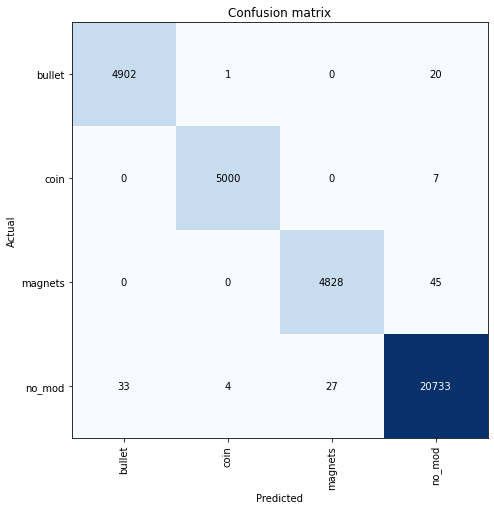

In [14]:
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [15]:
mat = interp.confusion_matrix()

In [2]:
mat = np.array([[4902,1,0,20],[0,5000,0,7],[0,0,4828,45],[33,4,27,20733]])

In [3]:
sens = np.diag(mat)/mat.sum(axis = 1)

In [4]:
categories = 'bullet coin magnets no_mod'.split(' ')

In [5]:
for category, sensitivity in zip(categories, sens):
    print(f'sensitivity/recall for class {category} is {sensitivity:.3f}')

sensitivity/recall for class bullet is 0.996
sensitivity/recall for class coin is 0.999
sensitivity/recall for class magnets is 0.991
sensitivity/recall for class no_mod is 0.997


In [6]:
precisions = np.diag(mat)/mat.sum(axis = 0)

In [7]:
for category, precision in zip(categories, precisions):
    print(f'precision for class {category} is {precision:.3f}')

precision for class bullet is 0.993
precision for class coin is 0.999
precision for class magnets is 0.994
precision for class no_mod is 0.997


In [8]:
cm  = mat

In [9]:
TP = np.diag(cm)
TP

array([ 4902,  5000,  4828, 20733])

In [10]:
FP = np.sum(cm, axis=0) - TP
FP

array([33,  5, 27, 72])

In [11]:
FN = np.sum(cm, axis=1) - TP
FN

array([21,  7, 45, 64])

In [12]:
num_classes = 4
TN = []
for i in range(num_classes):
    temp = np.delete(cm, i, 0)    # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))
TN

[30644, 30588, 30700, 14731]

In [13]:
specificities = TN/(TN+FP)

In [14]:
for category, specificity in zip(categories, specificities):
    print(f'specificity for class {category} is {specificity:.3f}')

specificity for class bullet is 0.999
specificity for class coin is 1.000
specificity for class magnets is 0.999
specificity for class no_mod is 0.995
